In [1]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import pandas as pd
from itertools import cycle
import seaborn as sns

def load_dataframe(fname):
    try:
        dataframe =  pickle.load(open(fname, 'rb'))
    except:
        raise ValueError('NO DATAFILE FOUND')

    dataframe.pop('rules', None)
    return dataframe

def signif(x, p):
    x = np.asarray(x)
    x_positive = np.where(np.isfinite(x) & (x != 0), np.abs(x), 10**(p-1))
    mags = 10 ** (p - 1 - np.floor(np.log10(x_positive)))
    return np.round(x * mags) / mags

def add_subplot_label(fig, label, x, y):
    fig.text(x, y, label, fontsize=36, fontweight='bold', va='top', ha='left')

CB_color_cycle = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#984ea3', '#f781bf', '#a65628',
                  '#999999', '#e41a1c', '#dede00']

mStyles = ["o","D",".",",","^","<",">","d","+","x","4","8","s","p","P","*","h","H","+","x","X","v","d","|","_"]

## Figure 1: Convergence ##

In [2]:
# Load data
dataframes = []
options = ['Q', 'M', 'X', 'Y', 'F', 'J', 'P', 'R', 'C', 'D']  # Example options
m = 5
fnames = [f"llama3_data/llama3_70b_converged_baseline_{'_'.join(options)}_-50_100_{m}mem_complete_24ps_0.5tmp.pkl",
          f"llama31_data/llama31_70b_converged_baseline_{'_'.join(options)}_-50_100_{m}mem_complete_24ps_0.5tmp.pkl",
          f"claude_data/claude_converged_baseline_{'_'.join(options)}_-50_100_5mem_complete_24ps_0.5tmp.pkl",
          f"llama2_data/llama2_70b_converged_baseline_{'_'.join(options)}_-50_100_{m}mem_complete_24ps_0.5tmp.pkl"]


for fname in fnames:
    frame = load_dataframe(fname)
    frame.pop('rules', None)
    dataframes.append(frame)

# load theory
fname = "theoretical_modelling/NG_theoretical_10.pkl"
theory_dataframe = pickle.load(open(fname, 'rb'))
average_bins = [theory_dataframe[k]['tracker']['outcome'] for k in range(len(theory_dataframe))]
theory_avg_outcome = pd.DataFrame(average_bins).mean(axis = 0)#np.mean(average_bins, axis = 0)
theory_steps = np.array(range(len(theory_avg_outcome)))

C:\Users\user\AppData\Local\Temp\ipykernel_2040\987003949.py:93: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


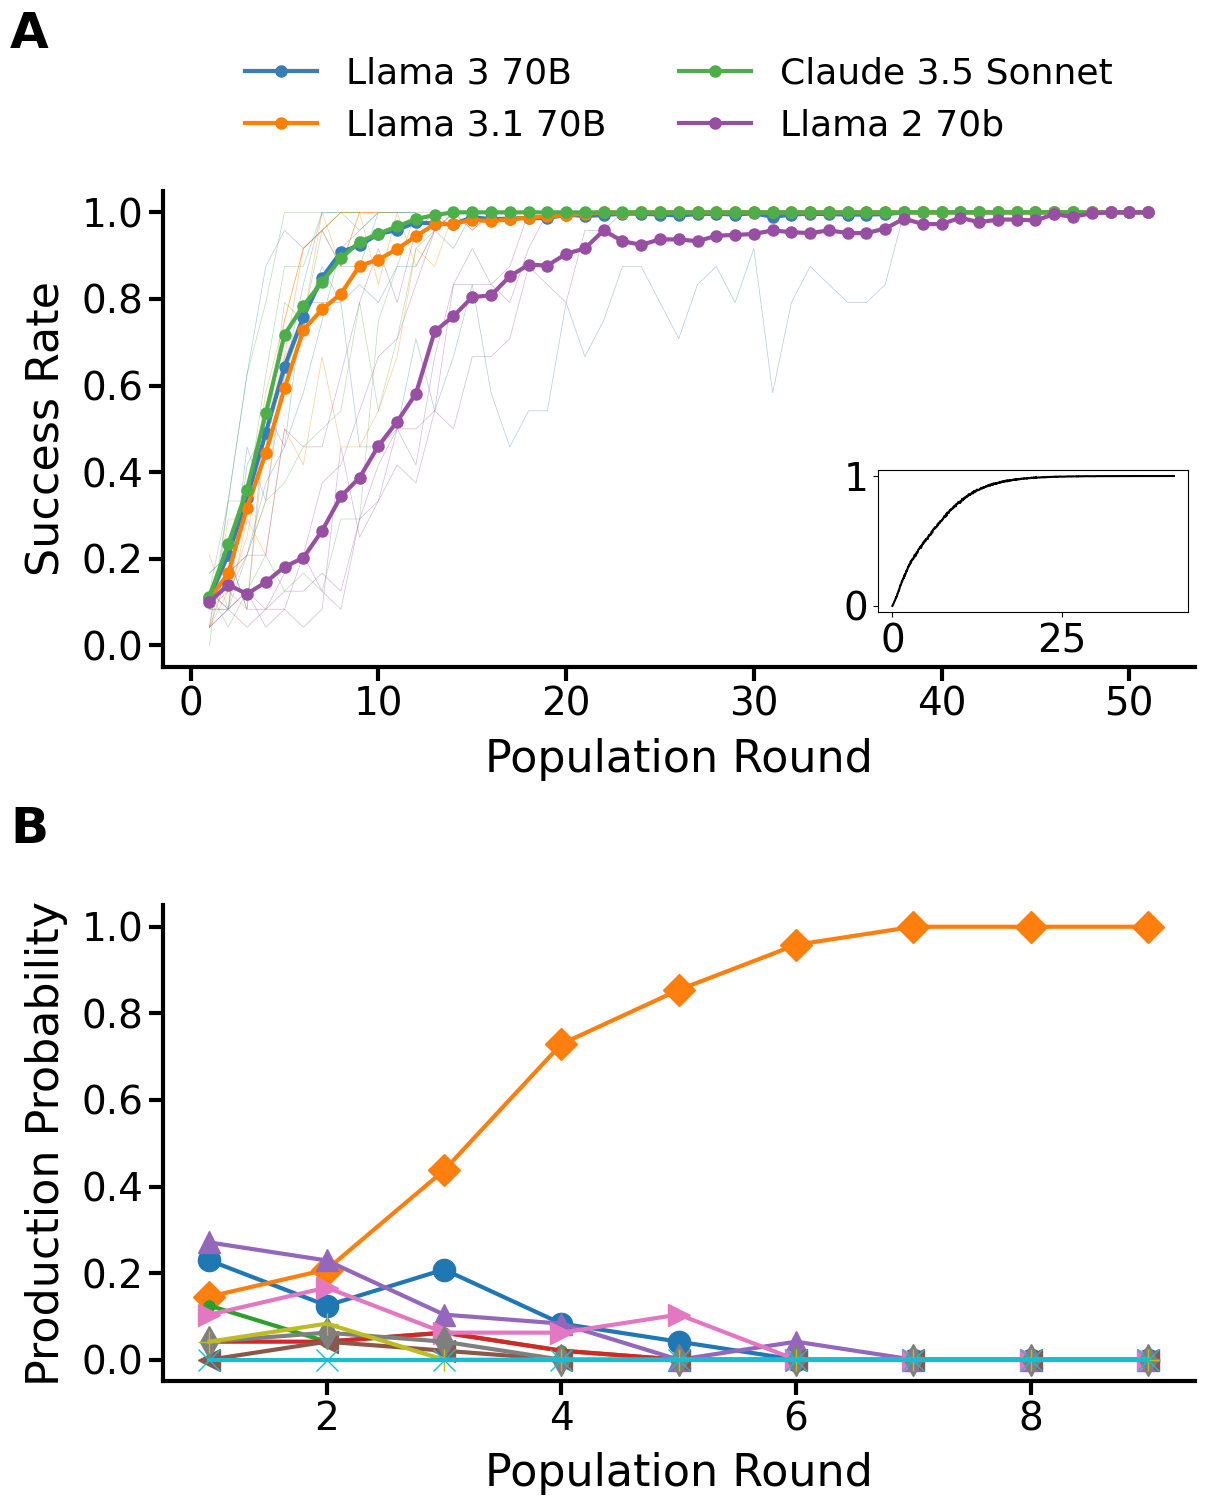

In [3]:
# plot figure 1
bin_size = 24
# Define the layout using mosaic
layout = """
AA
BB
"""

# Specify relative column widths to minimize the width of the central empty space
fig, axes = plt.subplot_mosaic(layout, 
                               figsize=(12, 15), 
                               gridspec_kw={'width_ratios': [10, 10],
                                            'height_ratios': [1, 1]})  # Adjust ratios to minimize the central space

# Plot something in each subplot
ax1 = axes['A']
colors = cycle(CB_color_cycle)
model_names=['Llama 3 70B', 'Llama 3.1 70B', 'Claude 3.5 Sonnet', 'Llama 2 70b']
# Color cycle
# Example options
markers = ['o', 'v', 's', 'd', '+']
model_bins = []
for dataframe in dataframes:
    model_color = next(colors)
    average_bins = []
    for k in list(dataframe.keys()):
        if len(dataframe[k]['tracker']['outcome']) == 0:
            print(f'run {k} has not finished yet!')
            break
        # plot results over binned time
        conv_index = 0
        #conv_index = dataframe[k]['convergence']['converged_index'] 
        bins = []
        # separate into population rounds
        for i in range(conv_index, len(dataframe[k]['tracker']['outcome']), bin_size):  #[dataframe[k]['converged_index']:]
            b = dataframe[k]['tracker']['outcome'][i:i + bin_size]
            bins.append(sum(b)/len(b))
        average_bins.append(bins)
        micro_steps = [((i+1)*bin_size)/len(dataframe[k]['simulation'].keys()) for i in range(0, len(bins))]  
        if k < 5:
            ax1.plot(micro_steps, bins, lw =0.5, color = model_color, alpha = 0.4)
    model_bins.append(average_bins)

longest_trajectory = max([len(trajectory) for trajectory in [x for xs in model_bins for x in xs]])
for i in range(len(model_names)):
    model_traj = [trajectory+[1]*(longest_trajectory-len(trajectory)) for trajectory in model_bins[i]]
    avg_outcome = pd.DataFrame(model_traj).mean(axis = 0)
    steps = [((i+1)*bin_size)/len(dataframe[k]['simulation'].keys()) for i in range(0, len(avg_outcome.values))]   
    #yerr = np.std(average_bins, axis=0)/np.sqrt(len(average_bins))
    ax1.plot(steps, avg_outcome.values, color=CB_color_cycle[i],
              ls='-', lw = 3, ms = 16, label = model_names[i], marker = '.')#, markerfacecolor = 'None')

ax1.set_ylabel('Success Rate', fontsize = 32, labelpad = 10)
ax1.set_xlabel('Population Round', fontsize = 32, labelpad = 10)
ax1.legend(loc='upper center', bbox_to_anchor=(0.5, 1.35), fontsize=26, ncols=2, frameon=False)  

axins = inset_axes(ax1, width="30%", height="30%", loc='lower right',
                  bbox_to_anchor=(0.0, 0.1, 1, 1), bbox_transform=ax1.transAxes)

#Plot the inset data
axins.plot(theory_steps/24, theory_avg_outcome, 'k', label='Model')
axins.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
axins.tick_params(axis='both', which='major', labelsize=28)

for j in range(len(options)):
    word = options[j]
    df = dataframes[1][6]
    bins = []
    for i in range(0, len(df['tracker']['answers']), bin_size):  
        b = [x for xs in df['tracker']['answers'][i:i+bin_size] for x in xs]
        bin_count = b.count(word)/len(b)
        bins.append(bin_count)
    steps = [((w+1)*bin_size)/len(df['simulation'].keys()) for w in range(len(bins))]
    axes['B'].plot(steps, bins, lw = 3, marker = mStyles[j], ms=16)#,  markerfacecolor = 'None')#, color = CB_color_cycle[1])#, 

#axes['C'].set_title('Single Run', fontsize = 20)
axes['B'].set_ylabel('Production Probability', fontsize = 32, labelpad = 10)
axes['B'].set_xlabel('Population Round', fontsize = 32, labelpad = 10)
#axes['B'].set_xticks(np.arange(len(steps)))
for k in axes.keys():
    axes[k].tick_params(axis='both', which='major', labelsize=28)
    axes[k].tick_params(axis='both', which='minor', labelsize=18, length=8) 
    axes[k].tick_params(width=3, length=10)
    for axis in ['left','bottom']:
        axes[k].spines[axis].set_linewidth(3)
    for axis in ['right','top']:
        axes[k].spines[axis].set_visible(False)

add_subplot_label(fig, 'A', 0.0, 1.)  # Label 'A'
add_subplot_label(fig, 'B', 0.0, 0.47)  # Label 'B'

# Adjust layout and display the plot
plt.tight_layout()
plt.subplots_adjust(hspace=0.5)
plt.savefig(f'figures/FIGURE_1.pdf', dpi = 1000, bbox_inches = 'tight', pad_inches = 0.15)

plt.show()

## Figure 2 ##

In [5]:
model_names=['Llama 3 70B Instruct', 'Llama 3.1 70B Instruct', 'Claude 3.5 Sonnet', 'Llama 2 70b Chat']
short_model_names=['Llama 3', 'Llama 3.1', 'Claude 3.5', 'Llama 2']
short_model_names=['Llama 3 70B', 'Llama 3.1 70B', 'Claude 3.5 Sonnet', 'Llama 2 70b']
# load data
all_options_counter1 = [6, 3, 1, 2, 2, 2, 1, 11, 5, 7]  # Llama 3 (40 runs)
all_options_counter2 = [1, 12, 4, 9, 1, 3, 3, 2, 4, 1]  # Llama 31 (40 runs)
all_options_counter3 = [4, 4, 2, 3, 0, 1, 0, 3, 7, 3] # Claude (27 runs)
all_options_counter4 = [0, 1, 0, 0, 0, 0, 1, 18, 0, 0] # llama 2 (20 runs)
all_options = [all_options_counter1,
               all_options_counter2,
               all_options_counter3,
               all_options_counter4]

# load individual bias
options = ['Q', 'M']

fnames = ["llama3", "llama31", "claude", "llama2"]

individual_bias_counts = []
for model in fnames:
    fname = f"{model}_data/{model}_no_memory_bias_test_{''.join([str(m) for m in options])}_0mem.pkl"
    dataframe = load_dataframe(fname = fname)
    counts = [dataframe['tracker']['answers'].count(option) for option in options]
    answers = sum(counts)
    individual_bias_counts.append(np.array(counts)/answers)
#individual_bias_counts += [[0,0]]

#converged results
collective_bias_counts = [[0, 40],[0, 40], [14, 26],[ 4, 36]]



In [6]:
# function for plotting categorical bars

def plot_bars(ax, A_frequencies, B_frequencies, categories, colors = CB_color_cycle, bar_width=0.35):
    # Set the width of each bar and the positions of the bars
    r1 = np.arange(len(categories))  # Positions for the first set of bars (A)
    r2 = [x + bar_width for x in r1]  # Positions for the second set of bars (B)

    # Create the vertical bars
    for i, (a_freq, b_freq) in enumerate(zip(A_frequencies, B_frequencies)):
        ax.bar(r1[i], a_freq, bar_width, color=colors[i], alpha=0.5, label=f'{categories[i]} A')
        ax.bar(r2[i], b_freq, bar_width, color=colors[i], label=f'{categories[i]} B')

    ax.set_xticks([r + bar_width / 2 for r in range(len(categories))])  # Position x-ticks between bars
    ax.tick_params(axis='both', which='major', labelsize=28, length = 2, pad = 10)
    ax.tick_params(axis='both', which='minor', labelsize=18)
    #ax.set_ylim(top=0.55)

[0.487, 0.5079, 0.5016, 0.501]
[40, 40, 26, 36]


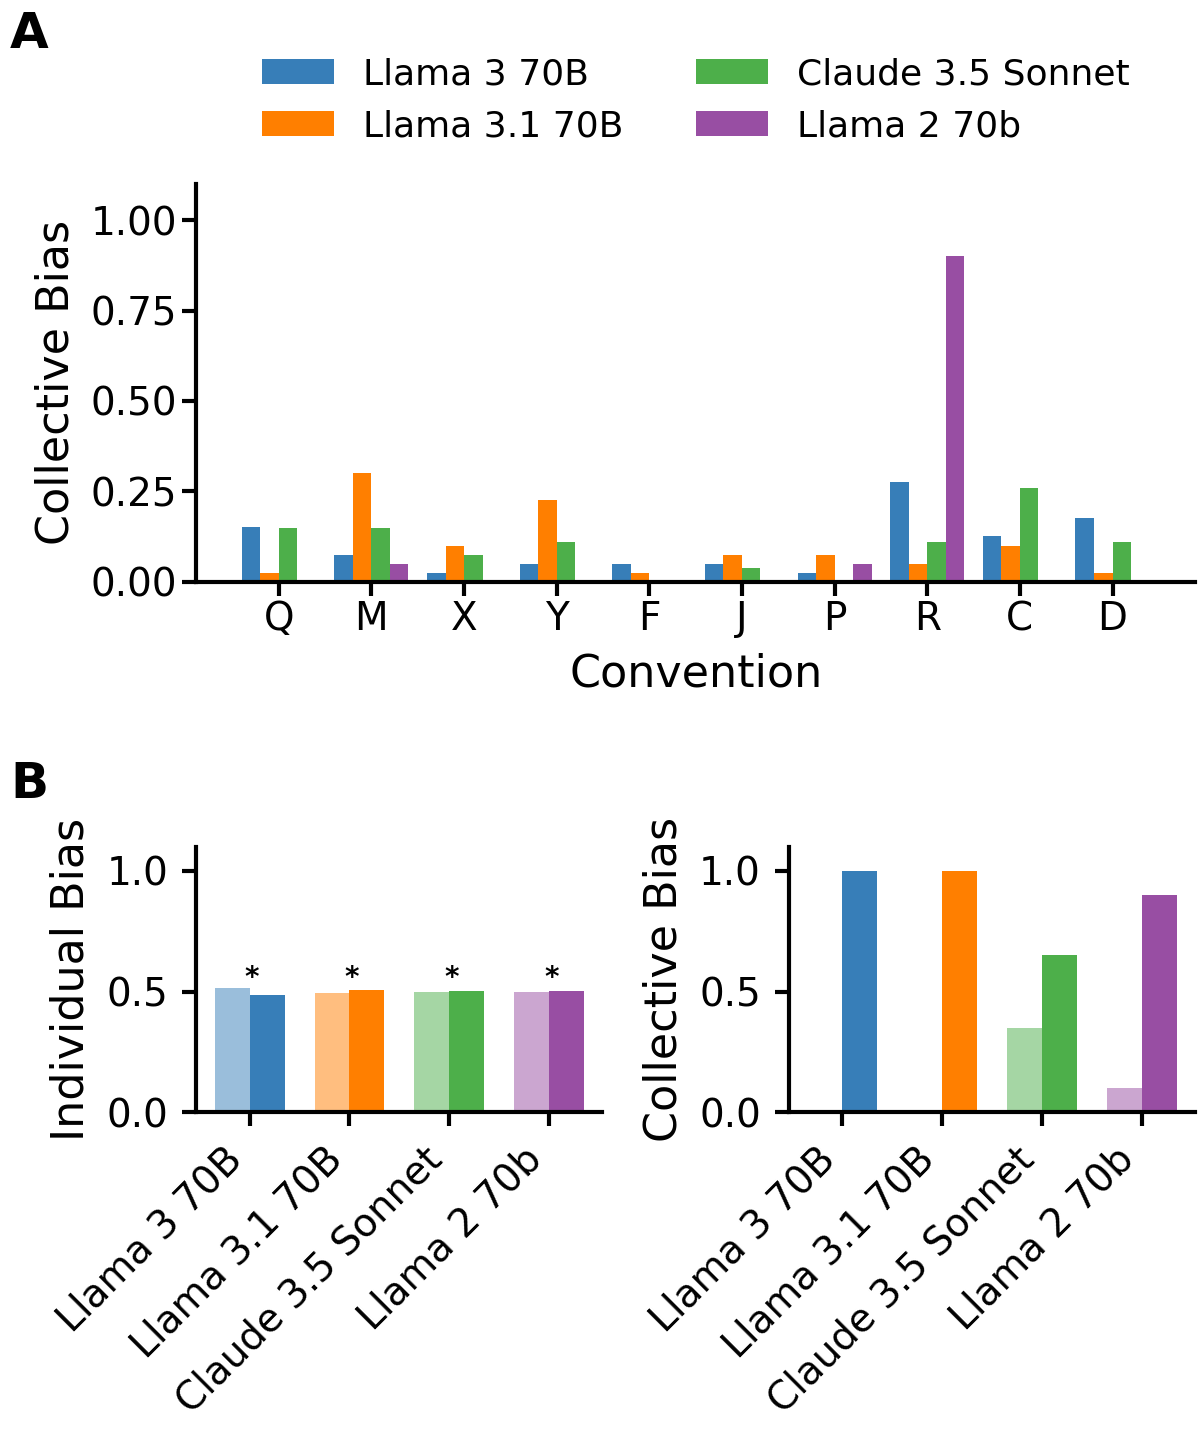

In [7]:
# plot figure

layout = """
BB
AC
"""

# Specify relative column widths to minimize the width of the central empty space
fig, axes = plt.subplot_mosaic(layout, 
                               figsize=(12, 15), 
                               gridspec_kw={'width_ratios': [1, 1],
                                            'height_ratios': [3, 2]},
                                            ) 

# plot top figure

ten_options = ['Q', 'M', 'X', 'Y', 'F', 'J', 'P', 'R', 'C', 'D']  
bar_width = 0.2  # Thin bars
x = np.arange(len(ten_options))  # X-axis positions for the bars

for i in range(len(model_names)):
    # Adjusting position of bars for each model by offsetting them horizontally
    offset = i * bar_width
    axes['B'].bar(x + offset, np.array(all_options[i]) / np.sum(all_options[i]), 
                  color=CB_color_cycle[i], width=bar_width, label=short_model_names[i]), 
                  #edgecolor='')

# Make sure to adjust the x-axis labels if needed
axes['B'].set_xticks(x + bar_width * (len(model_names) - 1) / 2)
axes['B'].set_xticklabels(ten_options)
axes['B'].legend(loc='upper center', bbox_to_anchor=(0.5, 1.4), fontsize=26, ncols=2, frameon=False)  
axes['B'].set_ylabel('Collective Bias', fontsize = 32, labelpad = 10)
axes['B'].set_xlabel('Convention', fontsize = 32, labelpad = 10)

#plot individual bias

plot_bars(ax=axes['A'], A_frequencies = [bias[0] for bias in individual_bias_counts],
 B_frequencies = [bias[1] for bias in individual_bias_counts],
 categories = short_model_names)#['']*len(model_names))
print([bias[1] for bias in individual_bias_counts])
plot_bars(ax=axes['C'], A_frequencies = [bias[0]/sum(bias) for bias in collective_bias_counts],
 B_frequencies = [bias[1]/sum(bias) for bias in collective_bias_counts],
 categories = short_model_names)
print([bias[1] for bias in collective_bias_counts])

# bottom row axis labels
axes['A'].set_ylabel('Individual Bias', fontsize=32, labelpad = 10)
axes['C'].set_ylabel('Collective Bias', fontsize=32, labelpad = 10)
axes['A'].set_xticklabels(short_model_names, fontsize=28, rotation = 45, ha= 'right')#
#short_model_names=['Llama 3', 'Llama 3.1', 'Claude 3.5', 'Llama 2']
axes['C'].set_xticklabels(short_model_names, fontsize=28, rotation = 45, ha= 'right')

# for key in ['A', 'C']:
#     ax = axes[key]
#     labels = ax.get_xticklabels()
#     positions = ax.get_xticks()

#     for label, position in zip(labels, positions):
#         ax.text(position, -0.1, label.get_text(), 
#                 ha='center', va='top', 
#                 transform=ax.get_xaxis_transform(),
#                 fontsize = 28, rotation = 45)

#     ax.set_xticklabels([])


r1 =  np.arange(len(short_model_names))
for i, (v_b) in enumerate([bias[1] for bias in individual_bias_counts]):

    axes['A'].text(r1[i]+bar_width,0.5, "*", color='black', fontweight='bold', va='bottom', ha='center', fontsize=20)
axes['A'].set_ylim(top=0.6)
for k in axes.keys():
    axes[k].tick_params(axis='both', which='major', labelsize=28)
    axes[k].tick_params(axis='both', which='minor', labelsize=18, length=8) 
    axes[k].tick_params(width=3, length=10)
    for axis in ['left','bottom']:
        axes[k].spines[axis].set_linewidth(3)
    for axis in ['right','top']:
        axes[k].spines[axis].set_visible(False)

    axes[k].set_ylim(top=1.1)

add_subplot_label(fig, 'A', 0.0, 0.95)  # Label 'A'
add_subplot_label(fig, 'B', 0.0, 0.45)  # Label 'B'
plt.tight_layout()
plt.subplots_adjust(hspace=0.8)
plt.savefig(f'figures/FIGURE_2.pdf', dpi = 1000, bbox_inches = 'tight', pad_inches = 0.15)

plt.show()

## COMMITTED MINORITIES ##

In [8]:
def did_converge(run):
        #conv_index = run['convergence']['converged_index'] 
        #print(run[-3:])
        #print(sum(run[-3:]))
        if sum(run[-3:]) < 2.849:
            return False
        return True

def non_cm_word_use(axs, dataframes, bin_size, cmap, norm, minority_size_set, max_round=30):

    #axs = axs.flatten()
    for dataframe, m in zip(dataframes, minority_size_set):
        f = m#/len(dataframe[0]['simulation'].keys())
        mkr = '.'#next(markers)
        c = cmap(norm(f)) #next(colors)
        average_bins = []
        #print(m)
        dataframe.pop('rules', None)
        print(dataframe.keys())
        for k in list(dataframe.keys()):
            if len(dataframe[k]['tracker']['outcome']) == 0:
                break
            

            #bin_size = len(dataframe[k]['simulation'].keys())
            #
            choice = dataframe[k]['convergence']['committed_to']
            if choice == options[0]:
                print(m)
                continue
            bins = []
            conv_index = dataframe[k]['convergence']['converged_index'] 
            committed_players = [player for player in dataframe[k]['simulation'].keys() if dataframe[k]['simulation'][player]['committed_tag'] == True]
            # separate into population rounds
            for i in range(conv_index, len(dataframe[k]['tracker']['answers']), bin_size):
                players = [x for xs in dataframe[k]['tracker']['players'][i:i+bin_size] for x in xs]
                b = [x for xs in dataframe[k]['tracker']['answers'][i:i+bin_size] for x in xs]
                filtered_data = [d for d, p in zip(b, players) if p not in committed_players]
                #print(len(b)==len(filtered_data))
                bins.append(filtered_data.count(choice)/len(filtered_data))
            micro_steps = [((i+1)*bin_size)/len(dataframe[k]['simulation'].keys()) for i in range(0, len(bins))]  
            #axs.plot(micro_steps, bins, lw =1, color = c, alpha = 0.4)
            average_bins.append(bins)
        #avg_outcome = pd.DataFrame(average_bins).mean(axis = 0)#np.mean(average_bins, axis = 0) 
        #steps = [((i+1)*bin_size)/(len(dataframe[k]['simulation'].keys())) for i in range(0, len(avg_outcome))]
        
        longest_trajectory = max([len(trajectory) for trajectory in average_bins])
        new_avg = []
        for trajectory in average_bins:
            if did_converge(trajectory):
                new_avg.append(trajectory+[1]*(longest_trajectory-len(trajectory)+30))
            else:
                new_avg.append(trajectory)

        average_bins = new_avg
        print(longest_trajectory)
        #average_bins = [trajectory+[1]*(longest_trajectory-len(trajectory)+max_round) for trajectory in average_bins]
        avg_outcome = pd.DataFrame(average_bins).mean(axis = 0).values[:max_round]

        steps = [((i+1)*bin_size)/len(dataframe[k]['simulation'].keys()) for i in range(0, len(avg_outcome))]
    #    yerr = np.std(average_bins, axis=0)/np.sqrt(len(average_bins))
        if did_converge(avg_outcome):
            # average_bins = [trajectory+[1]*(longest_trajectory-len(trajectory)+30) for trajectory in average_bins]
            # avg_outcome = pd.DataFrame(average_bins).mean(axis = 0).values[:30]

            # steps = [((i+1)*bin_size)/len(dataframe[k]['simulation'].keys()) for i in range(0, len(avg_outcome))]
            axs.plot(steps, avg_outcome, marker = 'o', color=c, ls='-', lw = 3, ms = 6, label = f"CM: {np.round(m/len(dataframe[k]['simulation'].keys()),2)}")
        else:
            axs.plot(steps, avg_outcome, marker = 'o', color=c, ls='--', lw = 3, ms = 6, label = f"CM: {np.round(m/len(dataframe[k]['simulation'].keys()),2)}", markerfacecolor = 'none')

    # axs.set_xlabel('Population Rounds', fontsize = 28)
    # axs.set_ylabel("Production Probability", fontsize = 28)

    axs.tick_params(axis='both', which='major', labelsize=28)
    axs.tick_params(axis='both', which='minor', labelsize=20) 
    axs.tick_params(width=3, length=10)
    axs.set_ylim(bottom = -0.05, top = 1.01)
    axs.set_xlim(left = -1, right = 31)
    axs.legend(fontsize = 18)
    #axs.legend(loc='center', bbox_to_anchor=(0.5, 1.2), fontsize=22, ncols = 4, frameon=False)       
    for axis in ['left','bottom']:
        axs.spines[axis].set_linewidth(3)
    for axis in ['right','top']:
        axs.spines[axis].set_visible(False)


def plot_word_use(axs, dataframe, bin_size):
    #word = list(set(dataframe[0]['simulation'][1]['my_history']))[0]

    average_bins = []
    for k in list(dataframe.keys()):
        if len(dataframe[k]['tracker']['outcome']) == 0:
            break
        
        conv_index = 0
        #conv_index = dataframe[k]['convergence']['converged_index']        
        
        history = [x for xs in dataframe[k]['tracker']['answers'][-3*len(dataframe[k]['simulation'].keys()):] for x in xs]
        word = max(set(history), key = history.count)
        #word = 'J'
        # word = dataframe[k]['convergence']['committed_to']
        print(word,history.count(word))
        bins = []
        # separate into population rounds
        for i in range(conv_index, len(dataframe[k]['tracker']['answers']), bin_size):  
            b = [x for xs in dataframe[k]['tracker']['answers'][i:i+bin_size] for x in xs]
            bins.append(b.count(word)/len(b))
        average_bins.append(bins)
        micro_steps = [((i+1)*bin_size)/len(dataframe[k]['simulation'].keys()) for i in range(0, len(bins))]  
        axs.plot(micro_steps, bins, lw =0.5, color = 'k', alpha = 0.4)
    longest_trajectory = max([len(trajectory) for trajectory in average_bins])
    average_bins = [trajectory+[1]*(longest_trajectory-len(trajectory)) for trajectory in average_bins]
    avg_outcome = pd.DataFrame(average_bins).mean(axis = 0)

    steps = [((i+1)*bin_size)/len(dataframe[k]['simulation'].keys()) for i in range(0, len(avg_outcome.values))]
  
    axs.plot(steps, avg_outcome, marker = '.', color='k', ls = '-', lw = 3, ms = 10)
    axs.set_xlabel('Population Rounds', fontsize = 20)
    axs.set_ylabel(f"Produciton probability (winner)", fontsize = 20)

dict_keys([0, 1, 2, 3, 4])
21
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15])
27
dict_keys([0, 1])
21
dict_keys([0, 1, 2, 3, 4])
21
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
24
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
42
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
34
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
42
dict_keys([0, 1, 2, 3, 4, 5])
16
dict_keys([0, 1, 2, 3, 4, 5])
27
dict_keys([0, 1, 2])
16
dict_keys([0, 1, 2])
32
dict_keys([0, 1, 2])
34
dict_keys([0, 1, 2])
34


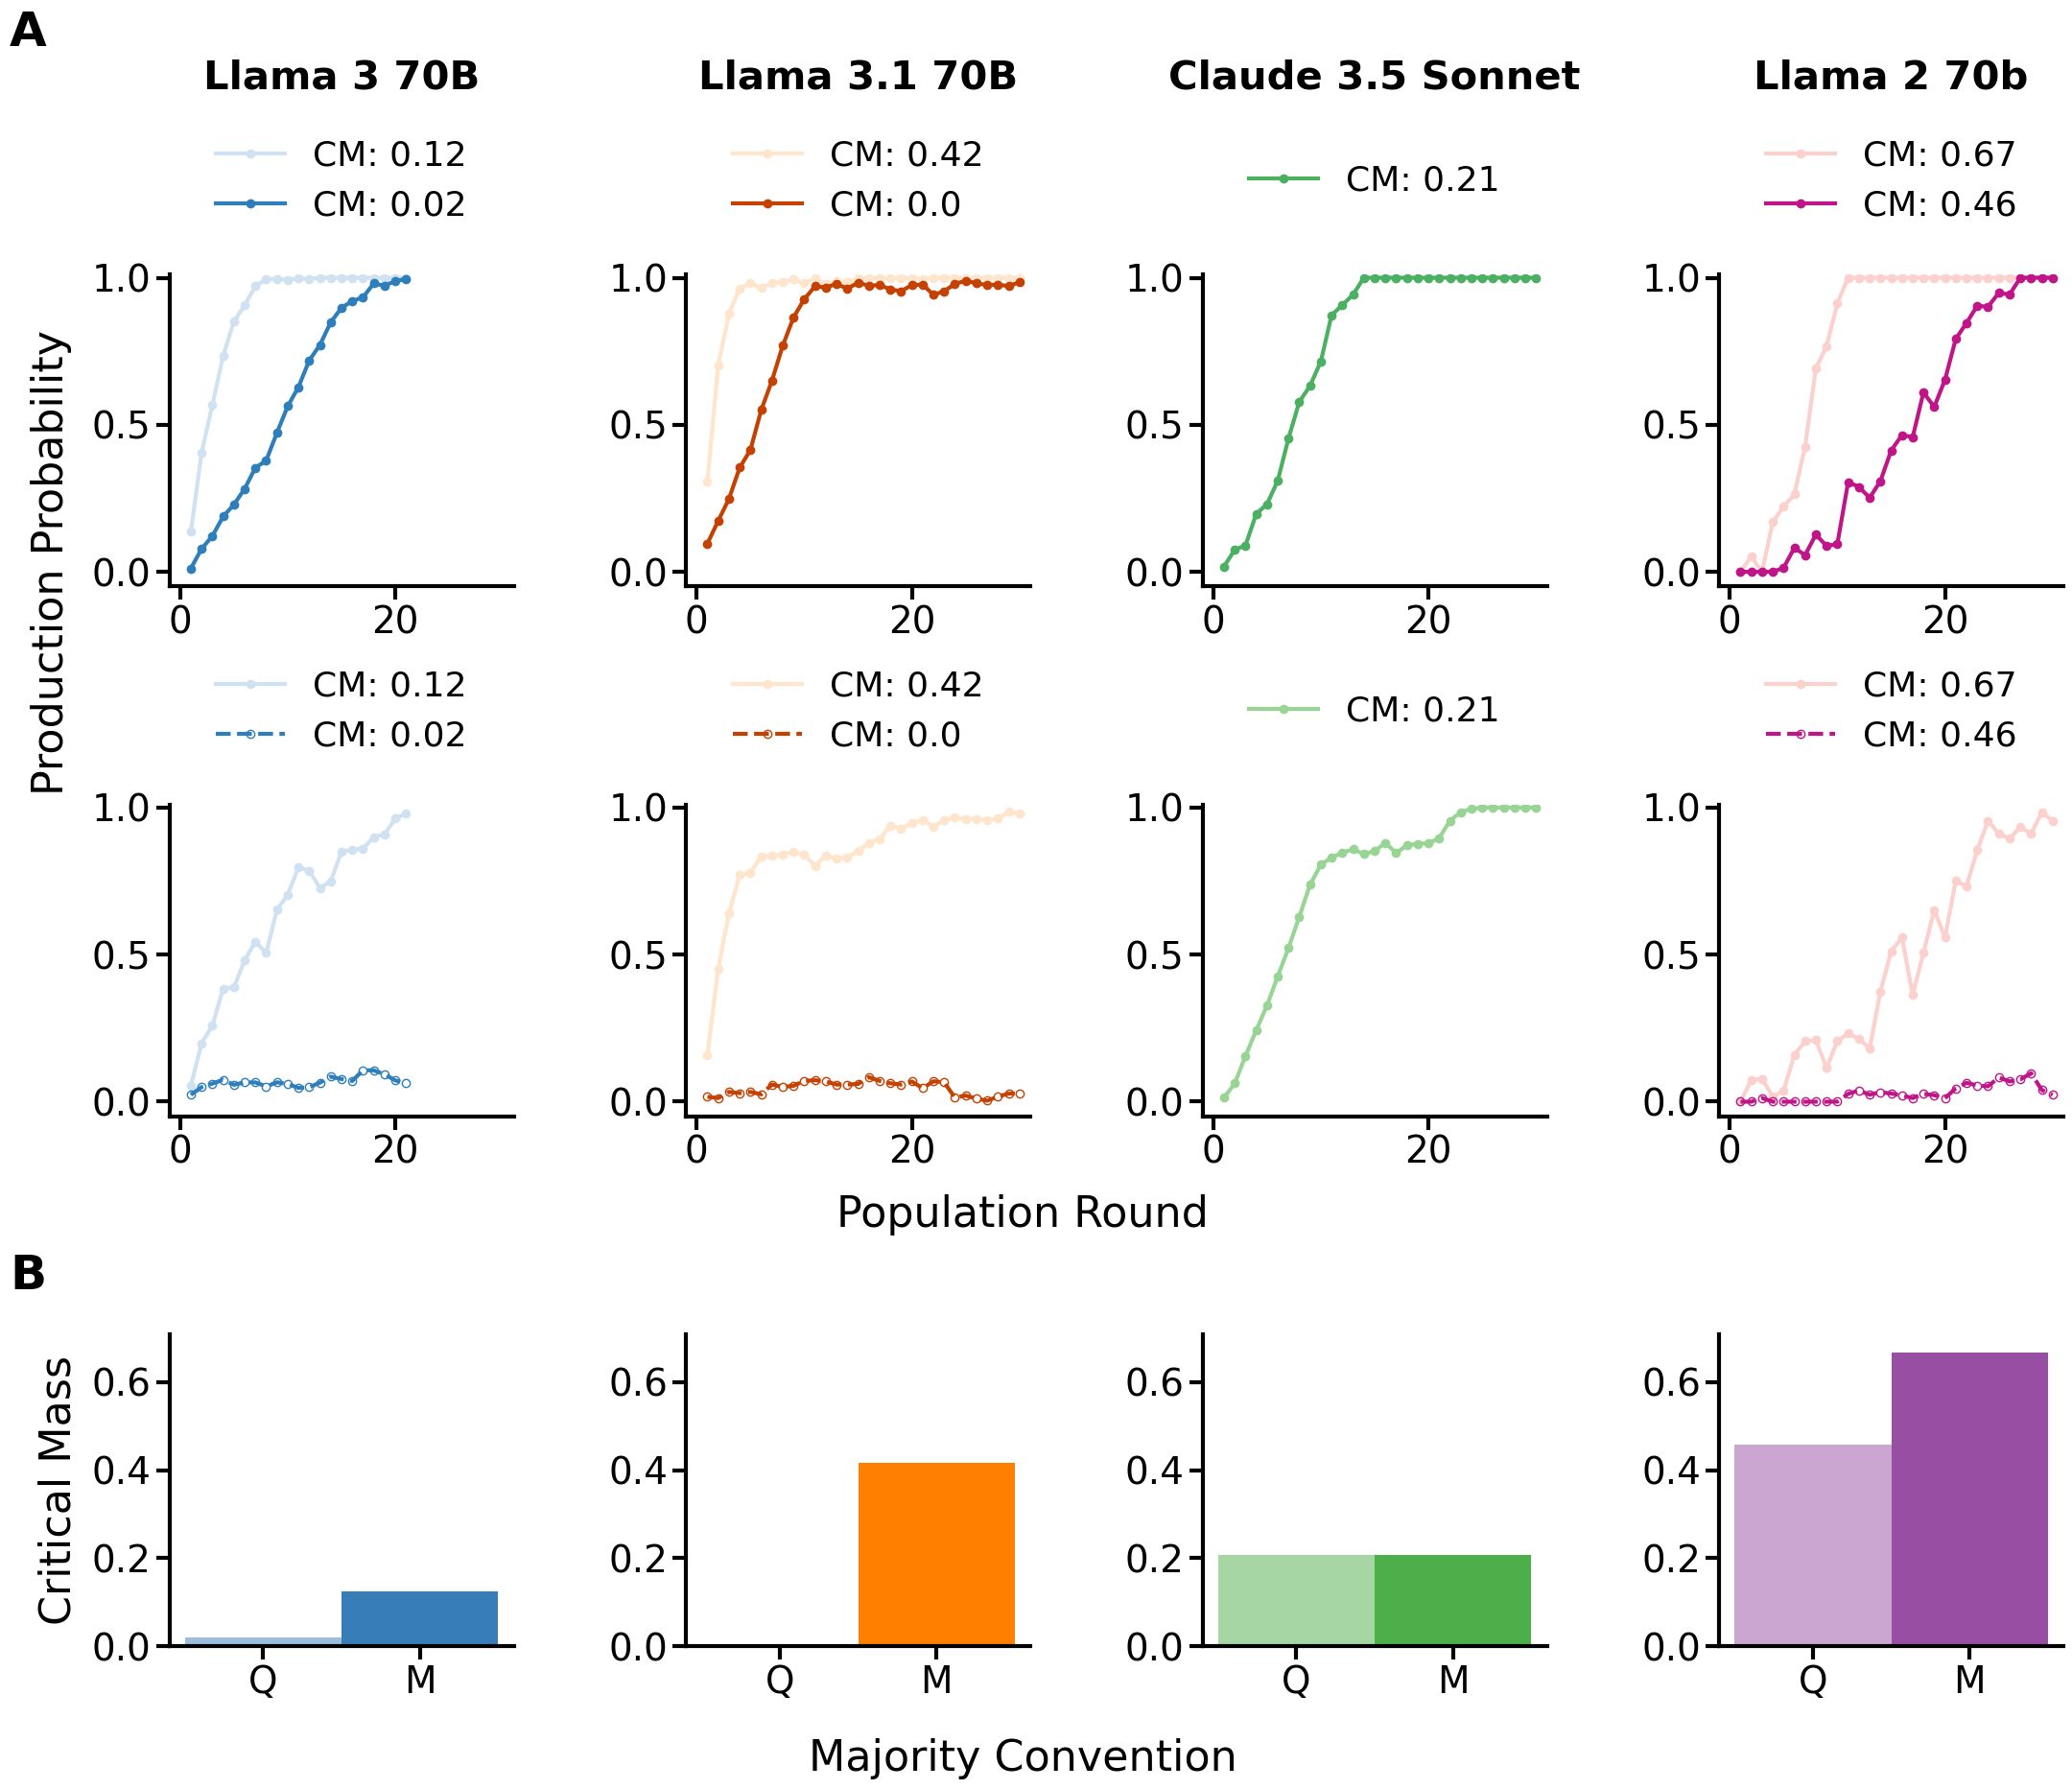

In [14]:
# LOAD DATA
options_list = [['Q', 'M'], ['M', 'Q']]
model_names = ['llama3_data/llama3_70b', 'llama31_data/llama31_70b', 'claude_data/claude', 'llama2_data/llama2']
minority_size_set_list = [[6,1],[10,0], [5], [16,11]]
mem = 3
N = 48
max_round = 21
#dfs_list = []
layout = """
BDFH
CEGI
A123
"""

# Specify relative column widths to minimize the width of the central empty space
fig, axes = plt.subplot_mosaic(layout, 
                               figsize=(22, 18),
                               gridspec_kw={
                                            'height_ratios': [1, 1, 1]},
                                            ) 
fig.supxlabel('Population Round', y=0.31, fontsize=32)
fig.supylabel("Production Probability", x=0.03, y=0.7, fontsize=32)
# plot bar plot
CM_strong = np.array([6,10,5,16])/np.array([48,24,24,24])
CM_weak = np.array([1,0,5,11])/np.array([48,24,24,24])
bar_axs = ['A', '1', '2', '3']
short_model_names=['Llama 3 70B Instruct', 'Llama 3.1 70B Instruct', 'Claude 3.5 Sonnet', 'Llama 2 70b Chat']#['Llama 3', 'Llama 3.1', 'Claude 3.5', 'Llama 2']
short_model_names=['Llama 3 70B', 'Llama 3.1 70B', 'Claude 3.5 Sonnet', 'Llama 2 70b']
index = [0, bar_width]
for i in range(len(bar_axs)):
    ax = axes[bar_axs[i]]
    # plot_bars(ax=axes[bar_axs[i]], A_frequencies = [CM_strong[i]],
    # B_frequencies = [CM_weak[i]],
    # categories = [short_model_names[i]],
    # colors = [CB_color_cycle[i]],
    # bar_width=0.15)
    
    ax.bar(index[0], CM_weak[i], bar_width, color=CB_color_cycle[i], alpha=0.5, label='Q')
    
    # Plot CM_strong with full alpha
    ax.bar(index[1], CM_strong[i], bar_width, color=CB_color_cycle[i], alpha=1.0, label='M')  
    #ax.set_xlabel("Majority Convention", fontsize=32)
    ax.set_xticks(index)
    ax.set_xticklabels(['Q', 'M'], fontsize=28)
    ax.set_ylim(top = 17/24)

axes['A'].set_ylabel('Critical Mass', fontsize = 32, labelpad = 10)
# plot production probabilities
keys = cycle(list(map(chr, range(ord('B'), ord('I')+1))))
cmaps = ['Blues_r', 'Oranges_r', 'Greens', 'RdPu_r']
for model, minority_size_set, cmap_label in zip(model_names, minority_size_set_list, cmaps):
    for options in options_list:
        key = next(keys)
        dfs = []
        for m in minority_size_set:
            if model != 'llama3_data/llama3_70b':
                mem = 5
                N = 24
                max_round = 30
            fname = f"{model}_swap_0_{m}cmtd_{options[0]}_{options[1]}_-50_100_{mem}mem_complete_{N}ps_0.5tmp.pkl"
            if model == 'llama31_data/llama31_70b' and m==0:
                fname = f"llama31_data/llama31_70b_evolved_from_0_{options[0]}_{options[1]}_-50_100_5mem_complete_24ps_1000ints_0.5tmp.pkl"
            try:
                dfs.append(pickle.load(open(fname, 'rb')))
            except:
                raise ValueError('NO DATAFILE FOUND')
        vmin = min(minority_size_set)-3
        vmax = max(minority_size_set)+2
        if model == 'claude_data/claude' and options == ['M', 'Q']:
            cmap_label = 'Greens_r'
        norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
        # cmap_label = 'Blues'
        # if options == options_list[0]:
        #     cmap_label = 'Reds'
        cmap = plt.get_cmap(cmap_label)
        non_cm_word_use(axs=axes[key], dataframes=dfs, bin_size=N, cmap = cmap, norm = norm, minority_size_set = minority_size_set, max_round =max_round)

bar_axs = ['C', 'E', 'G', 'I']
for i in range(len(bar_axs)):
    ax = axes[bar_axs[i]]
    ax.legend(loc='center', bbox_to_anchor=(0.5, 1.3), fontsize=26, ncols = 1, frameon=False) 

bar_axs = ['B', 'D', 'F', 'H']
for i in range(len(bar_axs)):
    ax = axes[bar_axs[i]]
    ax.set_title(short_model_names[i], fontsize=30, pad=140,  fontweight='bold')
    #ax.text(x = -3, y = 1.3, s = short_model_names[i], fontsize = 28, ha = 'left')
    ax.legend(loc='center', bbox_to_anchor=(0.5, 1.3), fontsize=26, ncols = 1, frameon=False)

for k in axes.keys():
    axes[k].tick_params(axis='both', which='major', labelsize=28)
    axes[k].tick_params(axis='both', which='minor', labelsize=18, length=8) 
    axes[k].tick_params(width=3, length=10)
    for axis in ['left','bottom']:
        axes[k].spines[axis].set_linewidth(3)
    for axis in ['right','top']:
        axes[k].spines[axis].set_visible(False)

# Function to add PNAS-style subplot labels


# Add subplot labels
add_subplot_label(fig, 'A', 0.02, 1.02)
add_subplot_label(fig, 'B', 0.02, 0.3)
fig.text(s='Majority Convention', x = 0.5, y=0, fontsize=32, ha = 'center')
# axes['B'].set_xlabel('Population Rounds', fontsize = 30, labelpad = 10)
# axes['B'].set_ylabel("Production Probability", fontsize = 30, labelpad = 10)
# axes['C'].set_ylabel("Production Probability", fontsize = 30, labelpad = 10)
#axes['Z'].remove()
plt.tight_layout()
plt.subplots_adjust(hspace=0.7, wspace = 0.5)
plt.savefig(f'figures/FIGURE_3.pdf', dpi = 1000, bbox_inches = 'tight', pad_inches = 0.15)
plt.show()
        


# SI FIGURES #

### Latin alphabet ###

In [16]:
# LOAD DATA 
options = list(map(chr, range(ord('A'), ord('Z')+1)))#['Q', 'M']
m = 5
fname = f"llama3_data/llama3_70b_converged_baseline_{'_'.join(options)}_-50_100_{m}mem_complete_24ps_0.5tmp.pkl"
dataframe = load_dataframe(fname = fname)

# individual bias
answers = []
for k in dataframe.keys():
    answer_per_player = [dataframe[k]['simulation'][p]['my_history'][0] for p in dataframe[k]['simulation'].keys()]
    answers +=answer_per_player

individual_bias_counts = np.array([answers.count(option) for option in options])/len(answers)


# collective bias
all_options_counter = [0]*len(options)
counter = 0
for i in list(dataframe.keys()):
    conv_index = dataframe[i]['convergence']['converged_index'] 
    history = [x for xs in dataframe[i]['tracker']['answers'][-72:] for x in xs]
    word = max(set(history), key = history.count)
    for i in range(len(options)):
        if word == options[i]:
            all_options_counter[i]+=1

collective_bias_counts = np.array(all_options_counter)/sum(all_options_counter)
print(sum(all_options_counter))

20


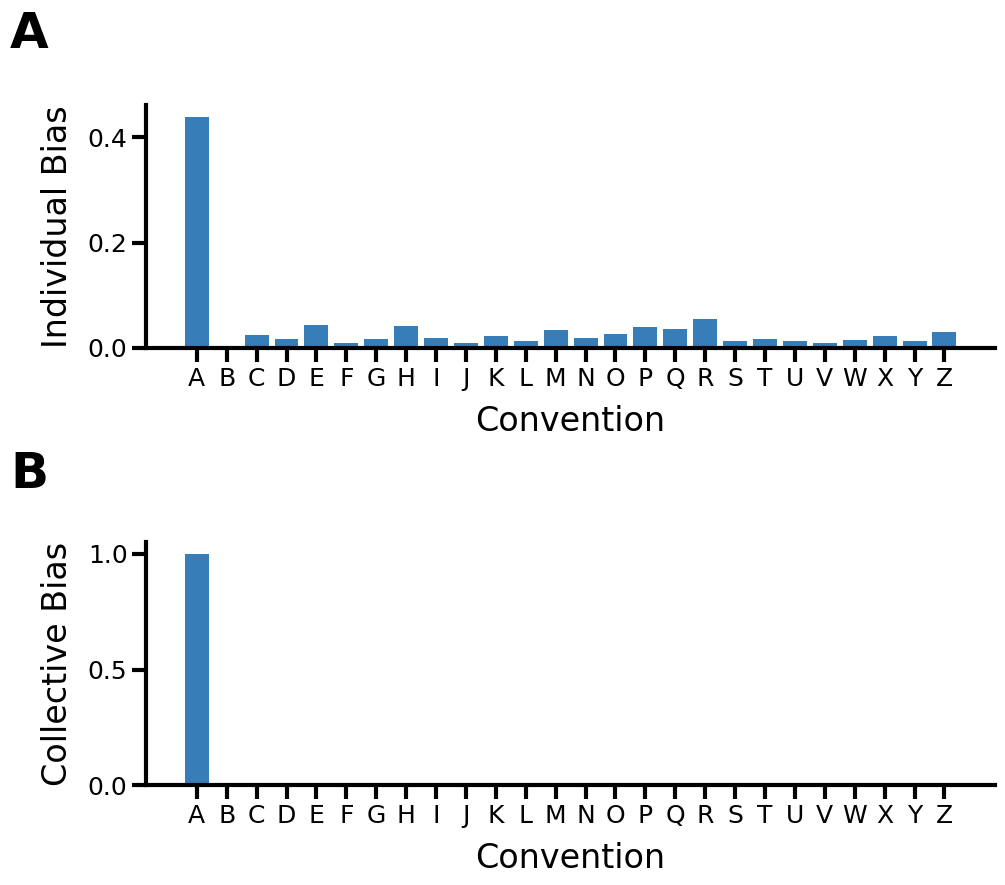

In [17]:
# plot figure
fig, axes = plt.subplots(ncols = 1, nrows = 2, figsize = (10,8))
axes = axes.flatten()
values = [individual_bias_counts, collective_bias_counts]
for ax, value in zip(axes, values):
    #ax = axes[k]
    rects = ax.bar(range(len(all_options_counter)), height = value, color = [CB_color_cycle[0]]*len(options))
    #ax.bar_label(rects, padding=3, fmt="{:#.4g}", fontsize = 18)
    ax.set_xticks(range(len(options)), options)
    ax.set_xlabel('Convention', fontsize = 24, labelpad = 10)
    ax.set_xticklabels(options)
    ax.tick_params(axis='both', which='major', labelsize=18)
    ax.tick_params(axis='both', which='minor', labelsize=18, length=8) 
    ax.tick_params(width=3, length=10)
    #ax.set_ylim(bottom = -0.01, top = 1.01)
    for axis in ['left','bottom']:
        ax.spines[axis].set_linewidth(3)
    for axis in ['right','top']:
        ax.spines[axis].set_visible(False)

axes[0].set_ylabel('Individual Bias', fontsize = 24, labelpad = 10)
axes[1].set_ylabel('Collective Bias', fontsize = 24, labelpad = 10)
# Add subplot labels
add_subplot_label(fig, 'A', 0.0, 1.1)
add_subplot_label(fig, 'B', 0.0, 0.55)
plt.tight_layout()
plt.subplots_adjust(hspace=0.8)#, wspace = 0.5)
plt.savefig(f'figures/SI_FIGURE_LATIN.pdf', dpi = 1000, bbox_inches = 'tight', pad_inches = 0.15)
plt.show()

### 10 letters empty memory bias ###

In [18]:
# LOAD DATA
options = ['Q', 'M', 'X', 'Y', 'F', 'J', 'P', 'R', 'C', 'D']
model_names = ['llama3_data/llama3', 'llama31_data/llama31', 'claude_data/claude', 'llama2_data/llama2']
#fname = "bias-tests/no_memory_bias_test_FJ_0mem.pkl"
fname_list = [f"{model}_no_memory_bias_test_{''.join([str(m) for m in options])}_0mem.pkl" for model in model_names]
individual_bias_counts = []
for fname in fname_list:
    dataframe = load_dataframe(fname = fname)

    # individual bias
    answers = [dataframe['tracker']['answers'].count(option) for option in options]

    individual_bias_counts.append(np.array(answers)/sum(answers))
    print(sum(answers))

15000
10000
4500
10000


In [12]:
print(individual_bias_counts[2]*4500)

[412. 477. 433. 463. 476. 438. 461. 434. 466. 440.]


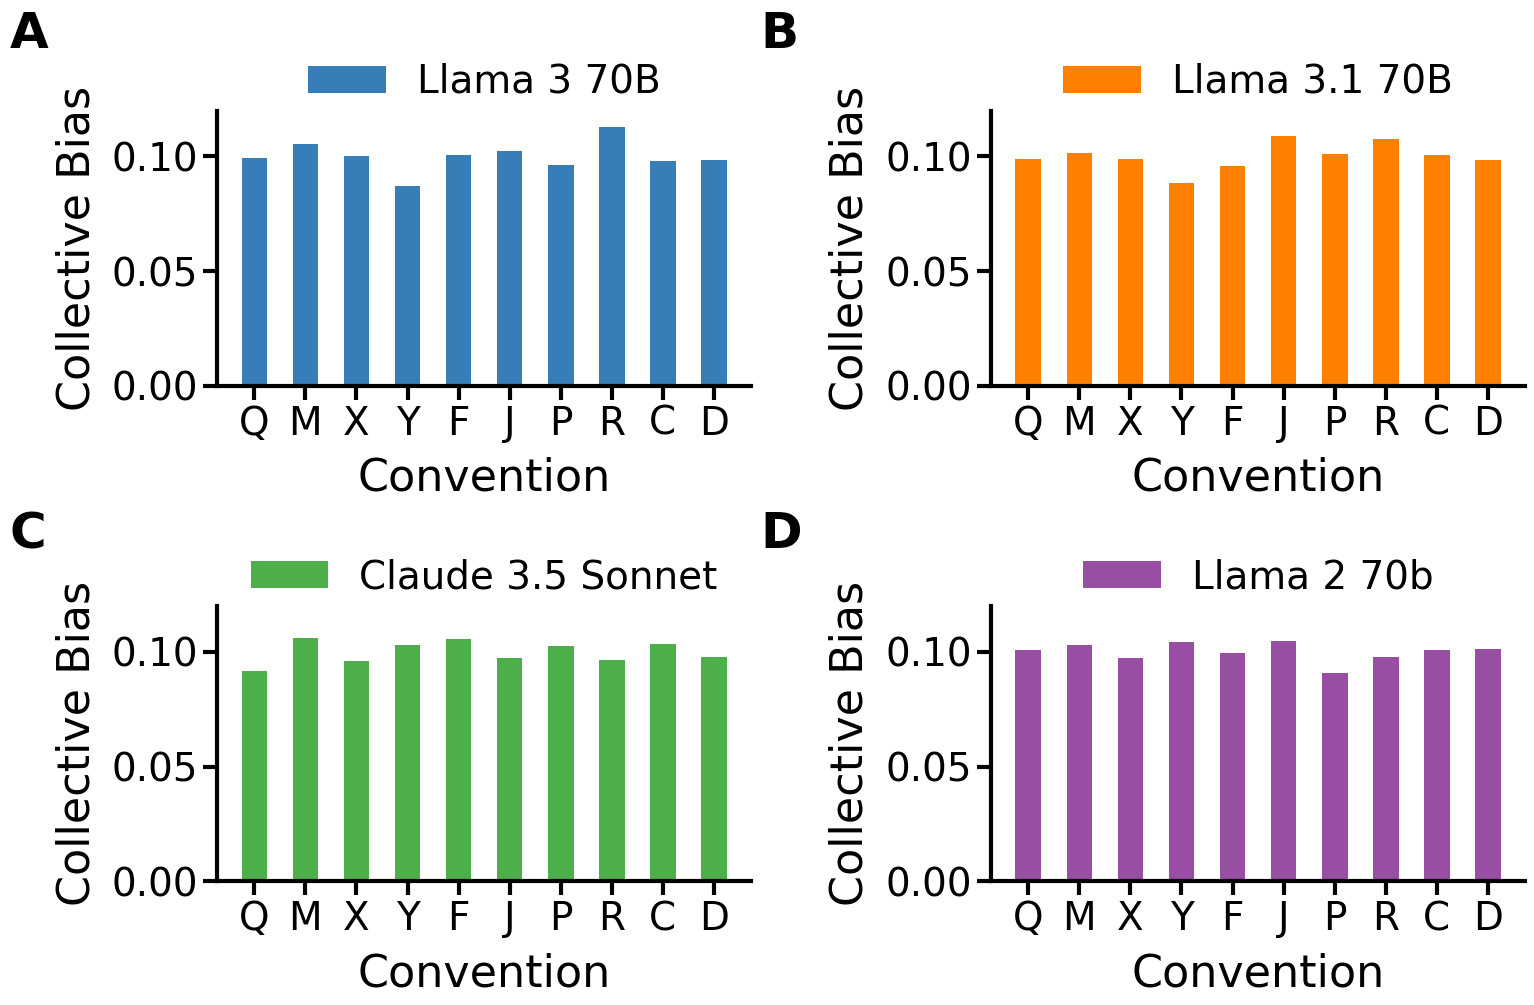

In [19]:
# plot figure
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (15,10))
axes = axes.flatten()
ten_options = ['Q', 'M', 'X', 'Y', 'F', 'J', 'P', 'R', 'C', 'D']  
bar_width = 0.5  # Thin bars
x = np.arange(len(ten_options))  # X-axis positions for the bars
model_names=['Llama 3 70B', 'Llama 3.1 70B', 'Claude 3.5 Sonnet', 'Llama 2 70b']
for i in range(len(model_names)):
    # Adjusting position of bars for each model by offsetting them horizontally
    #offset = i * bar_width
    ax = axes[i]
    ax.bar(x, individual_bias_counts[i], 
                  color=CB_color_cycle[i], width=bar_width, label=model_names[i]), 
                  #edgecolor='black')
    #ax.legend()

# Make sure to adjust the x-axis labels if needed
    ax.set_xticks(x)# + bar_width * (len(model_names) - 1) / 2)
    ax.set_xticklabels(ten_options)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), fontsize=28, ncols=2, frameon=False)  
    ax.set_ylabel('Collective Bias', fontsize = 32, labelpad = 10)
    ax.set_xlabel('Convention', fontsize = 32, labelpad = 10)
    ax.tick_params(axis='both', which='major', labelsize=28)
    ax.tick_params(axis='both', which='minor', labelsize=18, length=8) 
    ax.tick_params(width=3, length=10)
    for axis in ['left','bottom']:
        ax.spines[axis].set_linewidth(3)
    for axis in ['right','top']:
        ax.spines[axis].set_visible(False)
    ax.set_ylim(top = 0.12)

# fig.supxlabel('Convention', y=0.0, fontsize=32)
# fig.supylabel("Collective Bias", x=-0.05, y=0.5, fontsize=32)


add_subplot_label(fig, 'A', -0.02, 1.0)
add_subplot_label(fig, 'B', 0.48, 1.0)
add_subplot_label(fig, 'D', 0.48, 0.5)
add_subplot_label(fig, 'C',- 0.02, 0.5)
plt.tight_layout()
plt.subplots_adjust(hspace = 0.8, wspace = 0.45)
plt.savefig(f'figures/SI_FIGURE_10_individual_bias.pdf', dpi = 1000, bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

### Llama 3 binary naming game for 4 cases (2x8) plot ###

In [20]:
bin_size = 24
# success rate
def success_rate(ax, dataframe, df_color, df_marker = '.', df_label = ''):

    average_bins = []
    for k in list(dataframe.keys()):
        if len(dataframe[k]['tracker']['outcome']) == 0:
            print(f'run {k} has not finished yet!')
            break
        # plot results over binned time
        conv_index = 0
        #conv_index = dataframe[k]['convergence']['converged_index'] 
        bins = []
        # separate into population rounds
        for i in range(conv_index, len(dataframe[k]['tracker']['outcome']), bin_size): 
            b = dataframe[k]['tracker']['outcome'][i:i + bin_size]
            bins.append(sum(b)/len(b))
        average_bins.append(bins)
        micro_steps = [((i+1)*bin_size)/len(dataframe[k]['simulation'].keys()) for i in range(0, len(bins))]  
        #if k < 5:
        ax.plot(micro_steps, bins, lw =0.5, color = df_color, alpha = .4)

    longest_trajectory = max([len(trajectory) for trajectory in average_bins])
    average_bins = [trajectory+[1]*(longest_trajectory-len(trajectory)+30) for trajectory in average_bins]
    avg_outcome = pd.DataFrame(average_bins).mean(axis = 0).values[:30]
    steps = [((i+1)*bin_size)/len(dataframe[k]['simulation'].keys()) for i in range(0, len(avg_outcome))]   
    #yerr = np.std(average_bins, axis=0)/np.sqrt(len(average_bins))
    ax.plot(steps, avg_outcome, marker = df_marker, color=df_color, ls='-', lw = 3, ms = 10, label = df_label)
    # ax.set_xlabel('Population Rounds', fontsize = 30)
    # ax.set_ylabel('Success Rate', fontsize = 30)
    ax.tick_params(axis='both', which='major', labelsize=28)
    ax.tick_params(axis='both', which='minor', labelsize=18, length=8) 
    ax.tick_params(width=3, length=10)
    for axis in ['left','bottom']:
        ax.spines[axis].set_linewidth(3)
    for axis in ['right','top']:
        ax.spines[axis].set_visible(False)

    ax.set_ylim(bottom = 0.15, top = 1.01)

# word use 
def word_use(ax, dataframe, df_color, df_label, word):
    average_bins = []
    for k in list(dataframe.keys()):
        if len(dataframe[k]['tracker']['outcome']) == 0:
            print(f'run {k} has not finished yet!')
            break
        # plot results over binned time
        conv_index = dataframe[k]['convergence']['converged_index']
        #history = [x for xs in dataframe[k]['tracker']['answers'][conv_index-72:conv_index] for x in xs]
        #word = max(set(history), key = history.count)
        bins = []
        # separate into population rounds
        for i in range(0, len(dataframe[k]['tracker']['answers']), bin_size):  
            b = [x for xs in dataframe[k]['tracker']['answers'][i:i+bin_size] for x in xs]
            bins.append(b.count(word)/len(b))
        average_bins.append(bins)
        micro_steps = [((i+1)*bin_size)/len(dataframe[k]['simulation'].keys()) for i in range(0, len(bins))]  
        #if k < 5:
        ax.plot(micro_steps, bins, lw =.5, color = df_color)
        if k == 1:
            ax.plot(micro_steps, bins, lw =.5, color = df_color, label = word)

    # longest_trajectory = max([len(trajectory) for trajectory in average_bins])
    # average_bins = [trajectory+[1]*(longest_trajectory-len(trajectory)+30) for trajectory in average_bins]
    # avg_outcome = pd.DataFrame(average_bins).mean(axis = 0).values[:30]
    # steps = [((i+1)*bin_size)/len(dataframe[k]['simulation'].keys()) for i in range(0, len(avg_outcome))]   
    # #yerr = np.std(average_bins, axis=0)/np.sqrt(len(average_bins))
    # ax.plot(steps, avg_outcome, marker = '.', color=df_color, ls='-', lw = 3, ms = 10, label = df_label)
    # ax.set_xlabel('Population Rounds', fontsize = 30)
    # ax.set_ylabel('Production Probability', fontsize = 30)
    ax.tick_params(axis='both', which='major', labelsize=28)
    ax.tick_params(axis='both', which='minor', labelsize=18, length=8) 
    ax.tick_params(width=3, length=10)
    for axis in ['left','bottom']:
        ax.spines[axis].set_linewidth(3)
    for axis in ['right','top']:
        ax.spines[axis].set_visible(False)

    ax.set_ylim(bottom = -0.05, top = 1.01)

In [22]:
# LOAD DATA
options_list = [['Q', 'M'],['F', 'J'], ['X', 'Y'], ['Alice', 'Bob']]
m = 5
dfs = []
for options in options_list:
    fname = f"llama3_data/llama3_70b_converged_baseline_{'_'.join([str(m) for m in options])}_-50_100_{m}mem_complete_24ps_0.5tmp.pkl"
    dfs.append(load_dataframe(fname = fname))
    

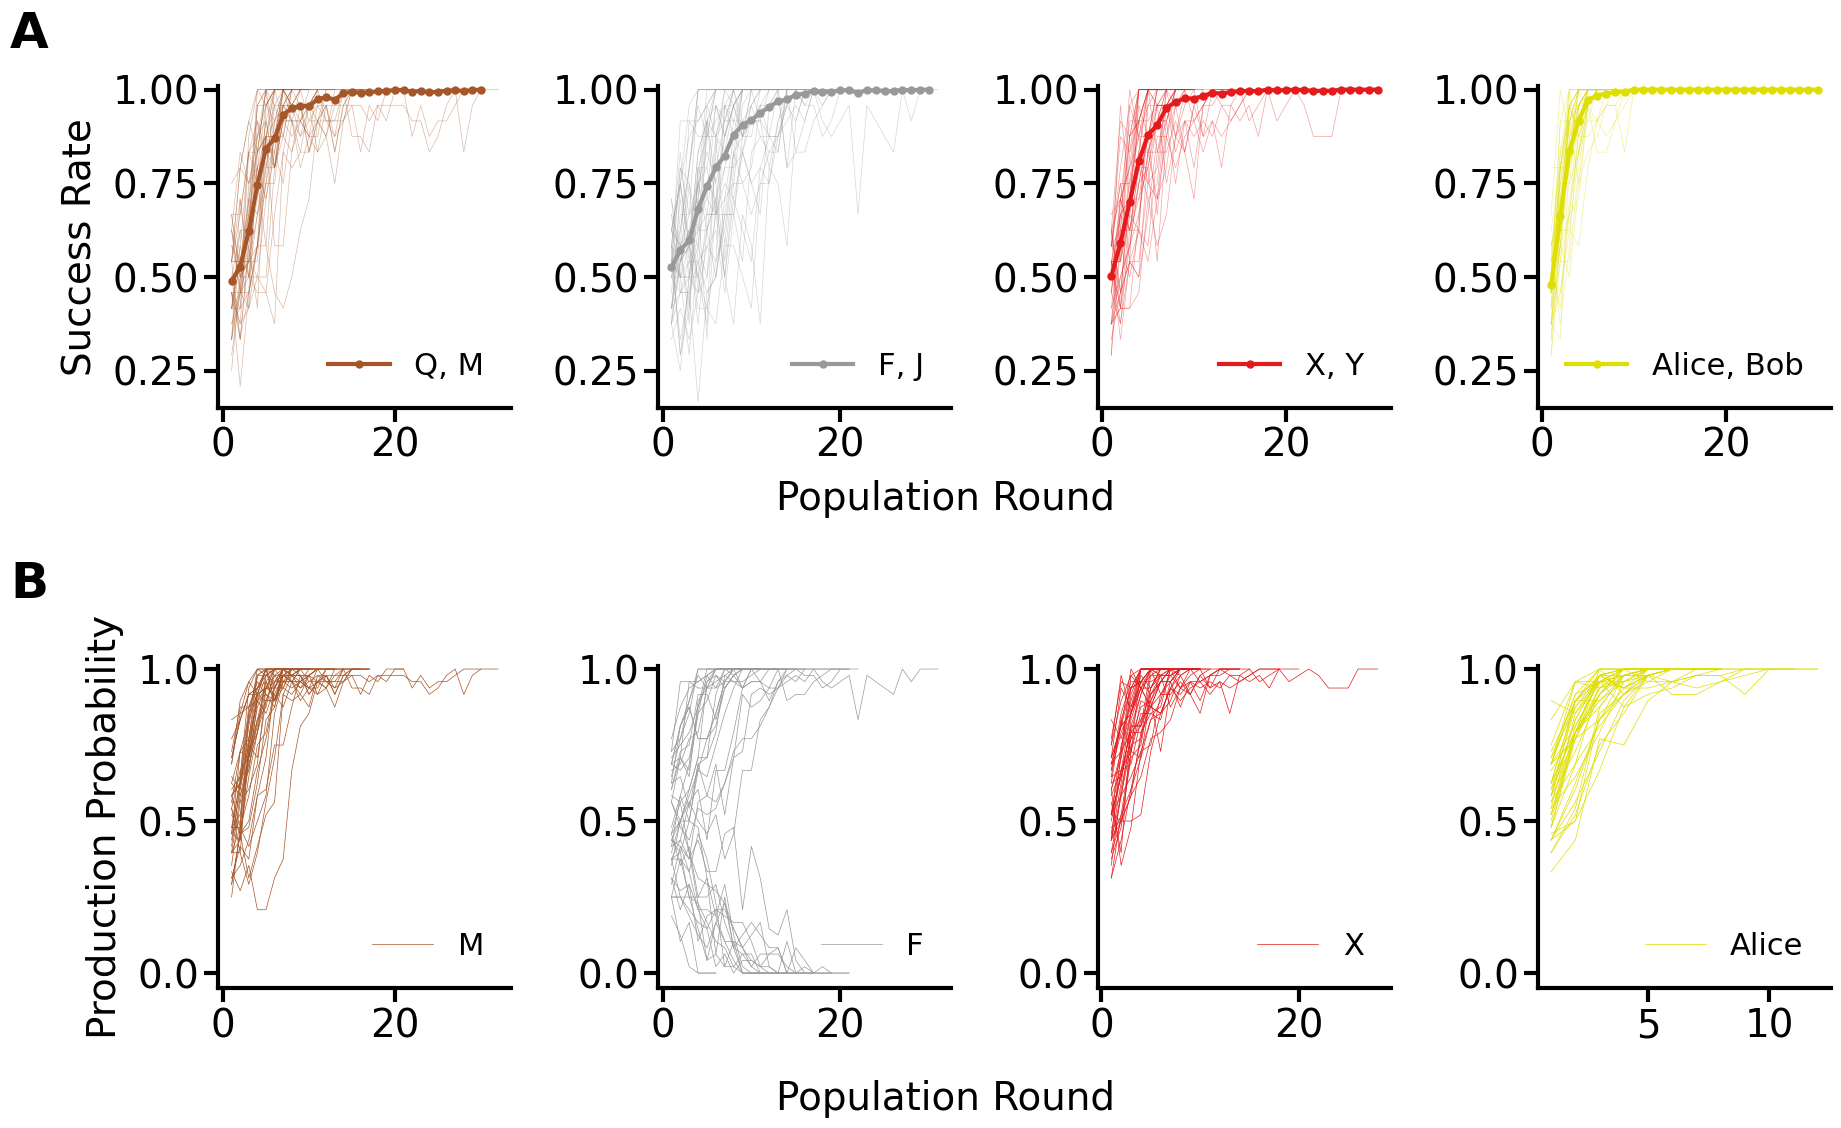

In [23]:
# plot figure for all 4 options
colors = CB_color_cycle[-4:]
fig, axs = plt.subplots(2, 4, figsize=(18, 10))
dom_label = []
words = ['M', 'F', 'X', 'Alice']
# Loop through the dataframes and plot each set of graphs
for i, df in enumerate(dfs):
    label = f", ".join(options_list[i])
    success_rate(axs[0, i], df, colors[i], df_label = label)
    #axs[0,i].set_title(f", ".join(options_list[i]), fontsize = 32, fontweight='bold', pad = 30)
    word_use(axs[1, i], df, colors[i], df_label =label, word = words[i])
    axs[0,i].legend(loc = 'lower right', fontsize = 22, frameon = False)
    axs[1,i].legend(loc = 'lower right', fontsize = 22, frameon = False)

#axs[0, 0].set_xlabel('Population Rounds', fontsize = 30)
axs[0, 0].set_ylabel('Success Rate', fontsize = 28, labelpad = 10)
#axs[1, 0].set_xlabel('Population Rounds', fontsize = 30)
axs[1, 0].set_ylabel('Production Probability', fontsize = 28, labelpad = 10)

add_subplot_label(fig, 'A', -0.02, 1.05)  # Label 'A'
add_subplot_label(fig, 'B', -0.02, 0.5)  # Label 'B'

fig.text(s='Population Round', x = 0.5, y=-0.05, fontsize=28, ha = 'center')

fig.text(s='Population Round', x = 0.5, y=0.55, fontsize=28, ha = 'center')
# Adjust layout
plt.tight_layout()
plt.subplots_adjust(hspace=0.8, wspace = 0.5)
plt.savefig(f'figures/SI_FIGURE_all_binary.pdf', dpi = 1000, bbox_inches = 'tight', pad_inches = 0.15)
plt.show()

### robustness convergence checks

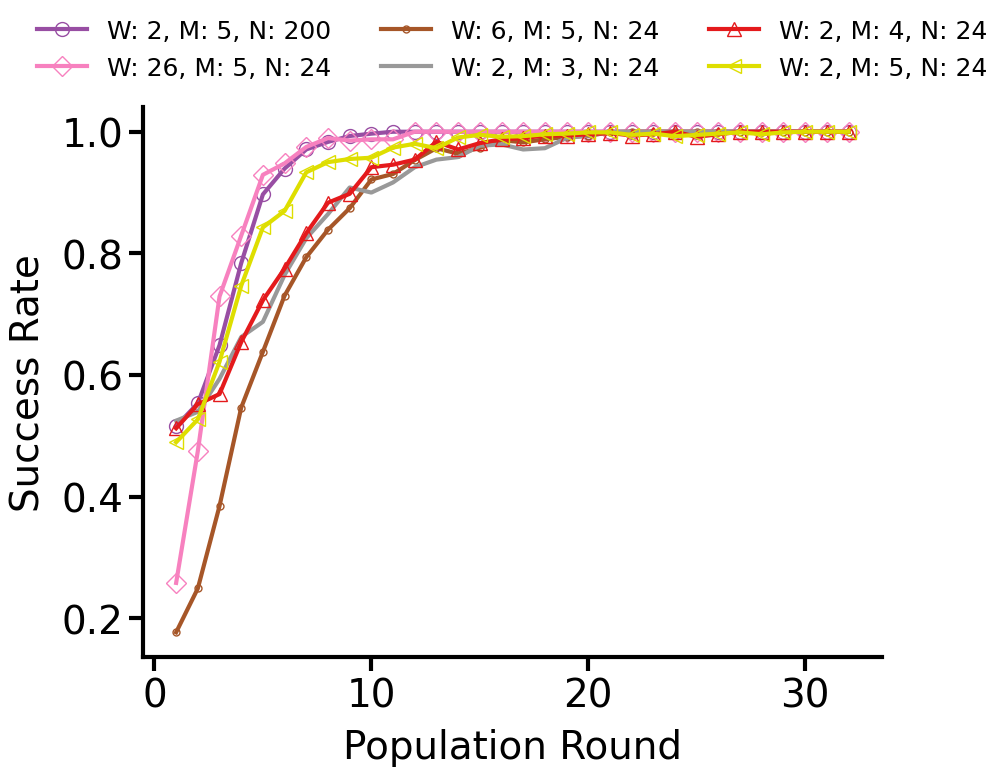

In [24]:
# Load data 
# large N
# large W
# W = 6
# different M
fname_list = ["llama3_data/llama3_70b_converged_baseline_Q_M_-50_100_5mem_complete_200ps_0.5tmp.pkl",
              "llama3_data/llama3_70b_converged_baseline_A_B_C_D_E_F_G_H_I_J_K_L_M_N_O_P_Q_R_S_T_U_V_W_X_Y_Z_-50_100_5mem_complete_24ps_0.5tmp.pkl",
              "llama3_data/llama3_70b_converged_baseline_Q_M_F_J_X_Y_-50_100_5mem_complete_24ps_0.5tmp.pkl",
              "llama3_data/llama3_70b_converged_baseline_Q_M_-50_100_3mem_complete_24ps_0.5tmp.pkl",
              "llama3_data/llama3_70b_converged_baseline_Q_M_-50_100_4mem_complete_24ps_0.5tmp.pkl",
              "llama3_data/llama3_70b_converged_baseline_Q_M_-50_100_5mem_complete_24ps_0.5tmp.pkl",
              ]
label_list = ["W: 2, M: 5, N: 200", 
              "W: 26, M: 5, N: 24", 
              "W: 6, M: 5, N: 24",
              "W: 2, M: 3, N: 24",
              "W: 2, M: 4, N: 24",
              "W: 2, M: 5, N: 24"]
fig, ax = plt.subplots(ncols = 1, nrows = 1, figsize = (10,8))

dataframes = []
for i in range(len(fname_list)):
    dataframe = load_dataframe(fname = fname_list[i])
    #success_rate(ax = ax, dataframe=dataframe, df_color=CB_color_cycle[-len(fname_list):][i], df_label=label_list[i], df_marker=mStyles[i])
    dataframes.append(dataframe)



model_bins = []
for dataframe in dataframes:
    bin_size = len(dataframe[0]['simulation'].keys())
    average_bins = []
    for k in list(dataframe.keys()):
        if len(dataframe[k]['tracker']['outcome']) == 0:
            print(f'run {k} has not finished yet!')
            break
        # plot results over binned time
        conv_index = 0
        #conv_index = dataframe[k]['convergence']['converged_index'] 
        bins = []
        # separate into population rounds
        for i in range(conv_index, len(dataframe[k]['tracker']['outcome']), bin_size):  #[dataframe[k]['converged_index']:]
            b = dataframe[k]['tracker']['outcome'][i:i + bin_size]
            bins.append(sum(b)/len(b))
        average_bins.append(bins)
        micro_steps = [((i+1)*bin_size)/len(dataframe[k]['simulation'].keys()) for i in range(0, len(bins))]  
        #if k < 5:
        #    ax.plot(micro_steps, bins, lw =0.5, color = model_color, alpha = 0.4)
    model_bins.append(average_bins)

longest_trajectory = max([len(trajectory) for trajectory in [x for xs in model_bins for x in xs]])
for i in range(len(dataframes)):
    model_traj = [trajectory+[1]*(longest_trajectory-len(trajectory)) for trajectory in model_bins[i]]
    avg_outcome = pd.DataFrame(model_traj).mean(axis = 0)
    steps = [((i+1)*bin_size)/len(dataframe[k]['simulation'].keys()) for i in range(0, len(avg_outcome.values))]   
    #yerr = np.std(average_bins, axis=0)/np.sqrt(len(average_bins))
    # ax.plot(steps, avg_outcome.values, color=CB_color_cycle[i],
    #           ls='-', lw = 3, ms = 16, label = model_names[i], marker = '.', markerfacecolor = 'None')
    ax.plot(steps, avg_outcome.values, marker = mStyles[i], color=CB_color_cycle[-len(fname_list):][i], ls='-', lw = 3, ms = 10, label = label_list[i], markerfacecolor = 'None')

ax.set_ylabel('Success Rate', fontsize = 28, labelpad = 10)
ax.set_xlabel('Population Round', fontsize = 28, labelpad = 10)
ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.2), fontsize=18, ncols=3, frameon=False)  
ax.tick_params(axis='both', which='major', labelsize=28)
ax.tick_params(axis='both', which='minor', labelsize=18, length=8) 
ax.tick_params(width=3, length=10)
for axis in ['left','bottom']:
    ax.spines[axis].set_linewidth(3)
for axis in ['right','top']:
    ax.spines[axis].set_visible(False)

plt.tight_layout()
plt.savefig(f'figures/SI_FIGURE_robust_emergence.pdf', dpi = 1000, bbox_inches = 'tight', pad_inches = 0.1)
plt.show()

### META PROMPTING TEST ###

In [26]:
# LOAD DATA
fnames = ["llama31_data/llama31_meta_test_final.pkl", "claude_data/claude_meta_prompting_final.pkl", "llama2_data/llama2_meta_test.pkl"]
dfs = []
for name in fnames:
    dfs.append(load_dataframe(fname = name))

# load llama3 data separately. the data file here was saved using a legacy method.

llama3_meta = load_dataframe("llama3_data/llama3_meta_prompting.pkl")

In [36]:
dfs[2][1]['min'].keys()

dict_keys(['answer', 'outcome'])

In [27]:
# GET AVERAGES
q_list = ['min', 'max', 'actions', 'payoff', 'round', 'action_i', 'points_i', 'no_actions', 'no_points']
results_list = []
for i in range(len(dfs)):
    tracker = dfs[i]
    results = {k: {} for k in q_list}
    if i == 2:
        for key in q_list:
            lol = [tracker[p][key]['outcome'] for p in tracker.keys()]
            #print(len([x for xs in lol for x in xs] ))
            #flat = [x for xs in lol for x in xs] 
            #results[key] = np.mean([x for xs in lol for x in xs] )
            data = [np.mean(tracker[p][key]['outcome']) for p in tracker.keys()]# if p<5]
            #num_data_points = sum([len(tracker[p][key]) for p in tracker.keys()])
            #print(num_data_points)
            results[key]['mean'] = np.mean(data)
            results[key]['std'] = np.std(data)/np.sqrt(len(tracker.keys()))
    else:
        for key in q_list:
            lol = [tracker[p][key] for p in tracker.keys()]
            #print(len([x for xs in lol for x in xs] ))
            #flat = [x for xs in lol for x in xs] 
            #results[key] = np.mean([x for xs in lol for x in xs] )
            data = [np.mean(tracker[p][key]) for p in tracker.keys()]# if p<5]
            #num_data_points = sum([len(tracker[p][key]) for p in tracker.keys()])
            #print(num_data_points)
            results[key]['mean'] = np.mean(data)
            results[key]['std'] = np.std(data)/np.sqrt(len(tracker.keys()))
    results_list.append(results)

In [38]:
results_list[2]

{'min': {'mean': 1.0, 'std': 0.0},
 'max': {'mean': 1.0, 'std': 0.0},
 'actions': {'mean': 1.0, 'std': 0.0},
 'payoff': {'mean': 0.8207091358454268, 'std': 0.020021051983383845},
 'round': {'mean': 1.0, 'std': 0.0},
 'action_i': {'mean': 0.9864263129160916, 'std': 0.0076559238161536015},
 'points_i': {'mean': 0.859182333835276, 'std': 0.026233522744881648},
 'no_actions': {'mean': 0.43838548751268536, 'std': 0.04093077099659901},
 'no_points': {'mean': 1.0, 'std': 0.0}}

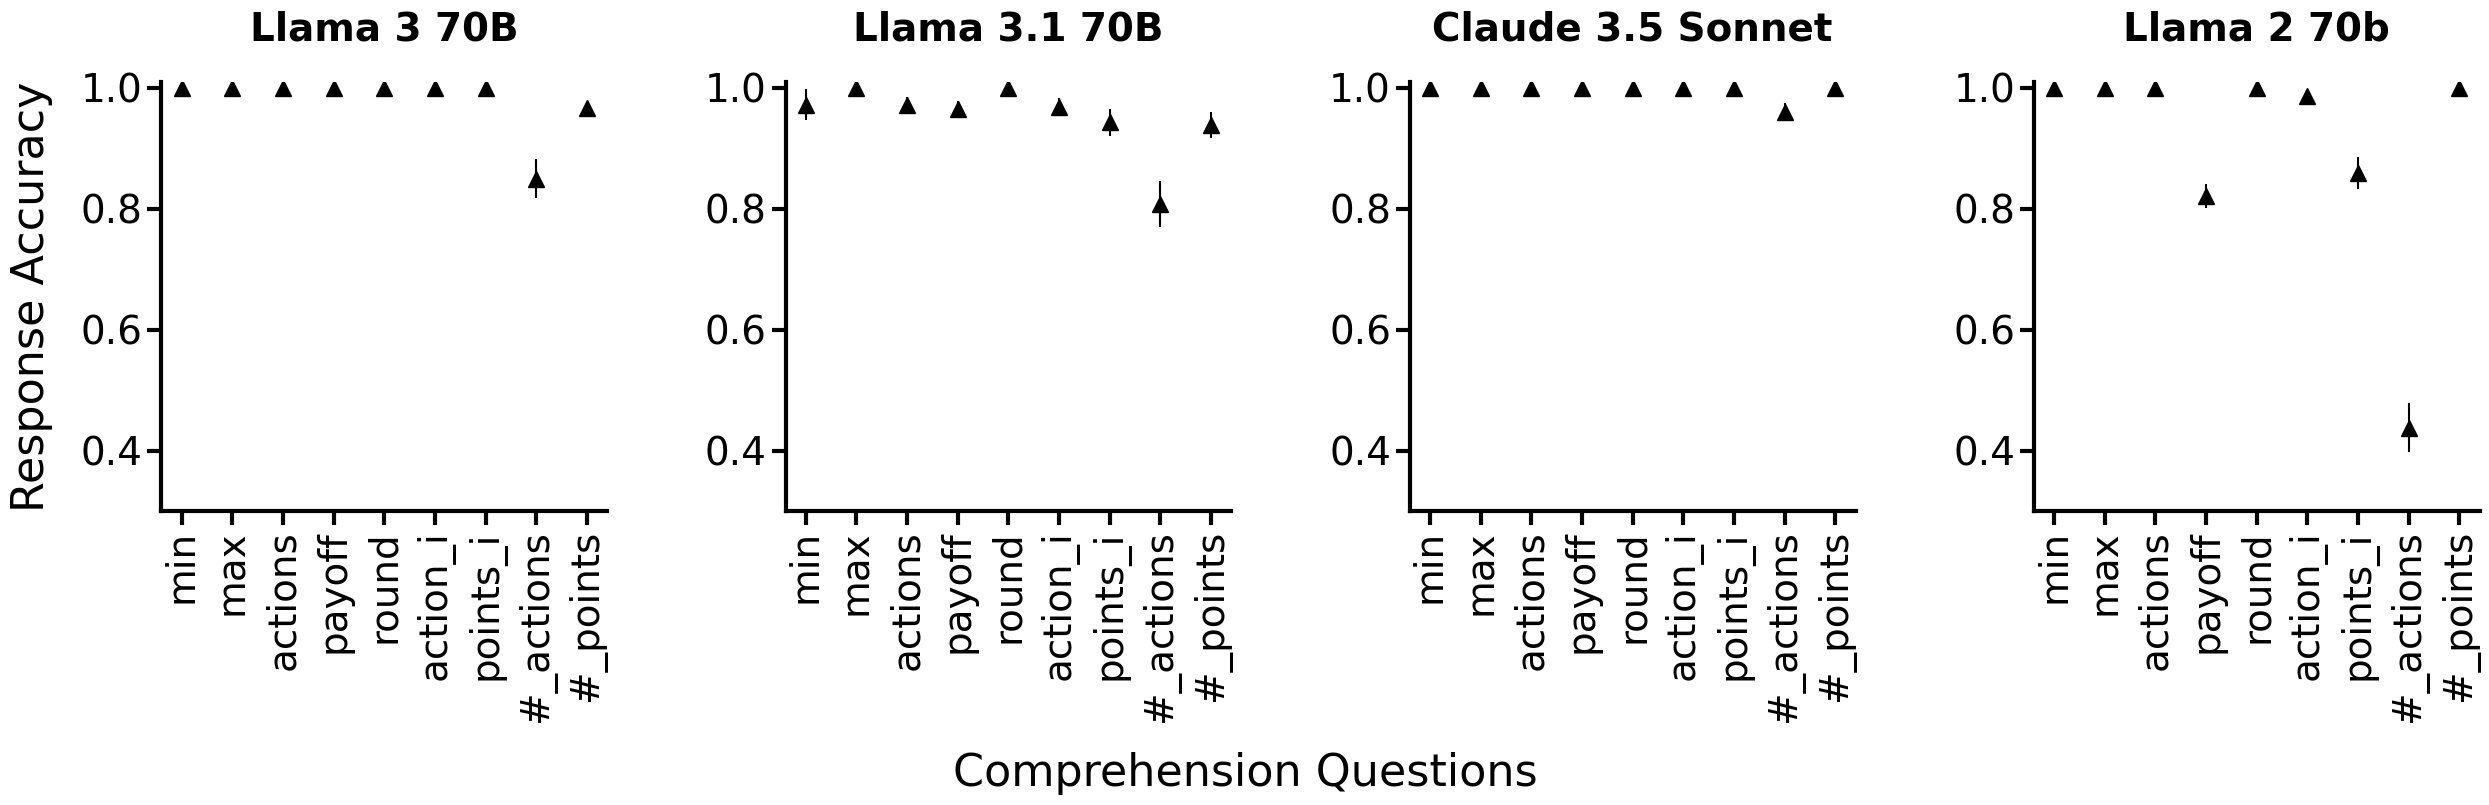

In [28]:
# PLOT
short_model_names=['Llama 3 70B', 'Llama 3.1 70B', 'Claude 3.5 Sonnet', 'Llama 2 70b']
# analysis function
def meta_test(results):
    y = [results[key]['mean'] for key in q_list]
    yerr = [results[key]['std'] for key in q_list] 
    return y, yerr


# create figure 
labels = ['min', 'max', 'actions', 'payoff', 'round', 'action_i', 'points_i', '#_actions', '#_points']
fig, axs = plt.subplots(1, 4, figsize=(25, 8))
axs = axs.flatten()
data = [([llama3_meta[l]['mean'] for l in labels], [llama3_meta[l]['std'] for l in labels])]+[meta_test(results_list[i]) for i in range(len(dfs))] + [()]
# get analysed data and plot
for i in range(len(axs)):
    ax = axs[i]
    y, yerr = data[i]
    ax.errorbar(range(len(y)), y=y,
                  ls = '', marker = '^', color = 'k',ms = 12,
                  yerr = yerr)
    ax.set_xticks(range(len(results.keys())), labels, rotation = 90, fontsize = 28)
    ax.tick_params(axis='both', which='major', labelsize=28)
    ax.tick_params(axis='both', which='minor', labelsize=18, length=8) 
    ax.tick_params(width=3, length=10)
    ax.set_ylim(bottom = 0.3, top = 1.01)
    for axis in ['left','bottom']:
        ax.spines[axis].set_linewidth(3)
    for axis in ['right','top']:
        ax.spines[axis].set_visible(False)
    ax.set_title(short_model_names[i], fontsize = 28, fontweight='bold', pad = 30)

fig.supxlabel('Comprehension Questions', y=0.0, fontsize=32)
#axs[0].set_xlabel("Comprehension Questions", fontsize = 32, labelpad = 20)
axs[0].set_ylabel("Response Accuracy", fontsize = 32, labelpad = 20)

plt.tight_layout()
plt.subplots_adjust(hspace=0.9, wspace = 0.4)
plt.savefig(f'figures/SI_FIGURE_meta_prompts.pdf', dpi = 1000, bbox_inches = 'tight', pad_inches = 0.1)
plt.show()


## STABILITY ANALYSIS ##

In [30]:
options = ['Q', 'M']
model_names = ['llama3_data/llama3', 'llama31', 'claude', 'llama2']
#fname = "bias-tests/no_memory_bias_test_FJ_0mem.pkl"
fname_list = ["llama3_data/llama3_70b_evolved_from_0_F_J_-50_100_5mem_complete_48ps_1000ints_0.5tmp.pkl",
            "llama3_data/llama3_70b_evolved_from_0_J_F_-50_100_5mem_complete_48ps_1000ints_0.5tmp.pkl",
            "llama31_data/llama31_70b_evolved_from_0_Q_M_-50_100_5mem_complete_24ps_1000ints_0.5tmp.pkl",
              "llama31_data/llama31_70b_evolved_from_0_M_Q_-50_100_5mem_complete_24ps_1000ints_0.5tmp.pkl",
                "claude_data/claude_evolved_from_0_Q_M_-50_100_5mem_complete_24ps_500ints_0.5tmp.pkl",
              "claude_data/claude_evolved_from_0_M_Q_-50_100_5mem_complete_24ps_500ints_0.5tmp.pkl",
              "llama2_data/llama2_evolved_from_0_Q_M_-50_100_5mem_complete_24ps_800ints_0.5tmp.pkl",
              "llama2_data/llama2_evolved_from_0_M_Q_-50_100_5mem_complete_24ps_800ints_0.5tmp.pkl"
              ]

# fname_list = ["llama_3_CM_with_score/llama3_70b_evolved_from_0_F_J_-50_100_5mem_complete_48ps_1000ints_0.5tmp.pkl",
#               "llama31_70b_evolved_from_0_Q_M_-50_100_5mem_complete_24ps_1000ints_0.5tmp.pkl",
#               "claude_evolved_from_0_Q_M_-50_100_5mem_complete_24ps_500ints_0.5tmp.pkl"
#               ]

dfs = []
for fname in fname_list:
    dataframe = load_dataframe(fname = fname)
    dfs.append(dataframe)

dfs = [dfs[i:i+2] for i in range(0, len(dfs), 2)]

In [27]:
len(dfs)

4

4
4
10
10
3
3
5
5


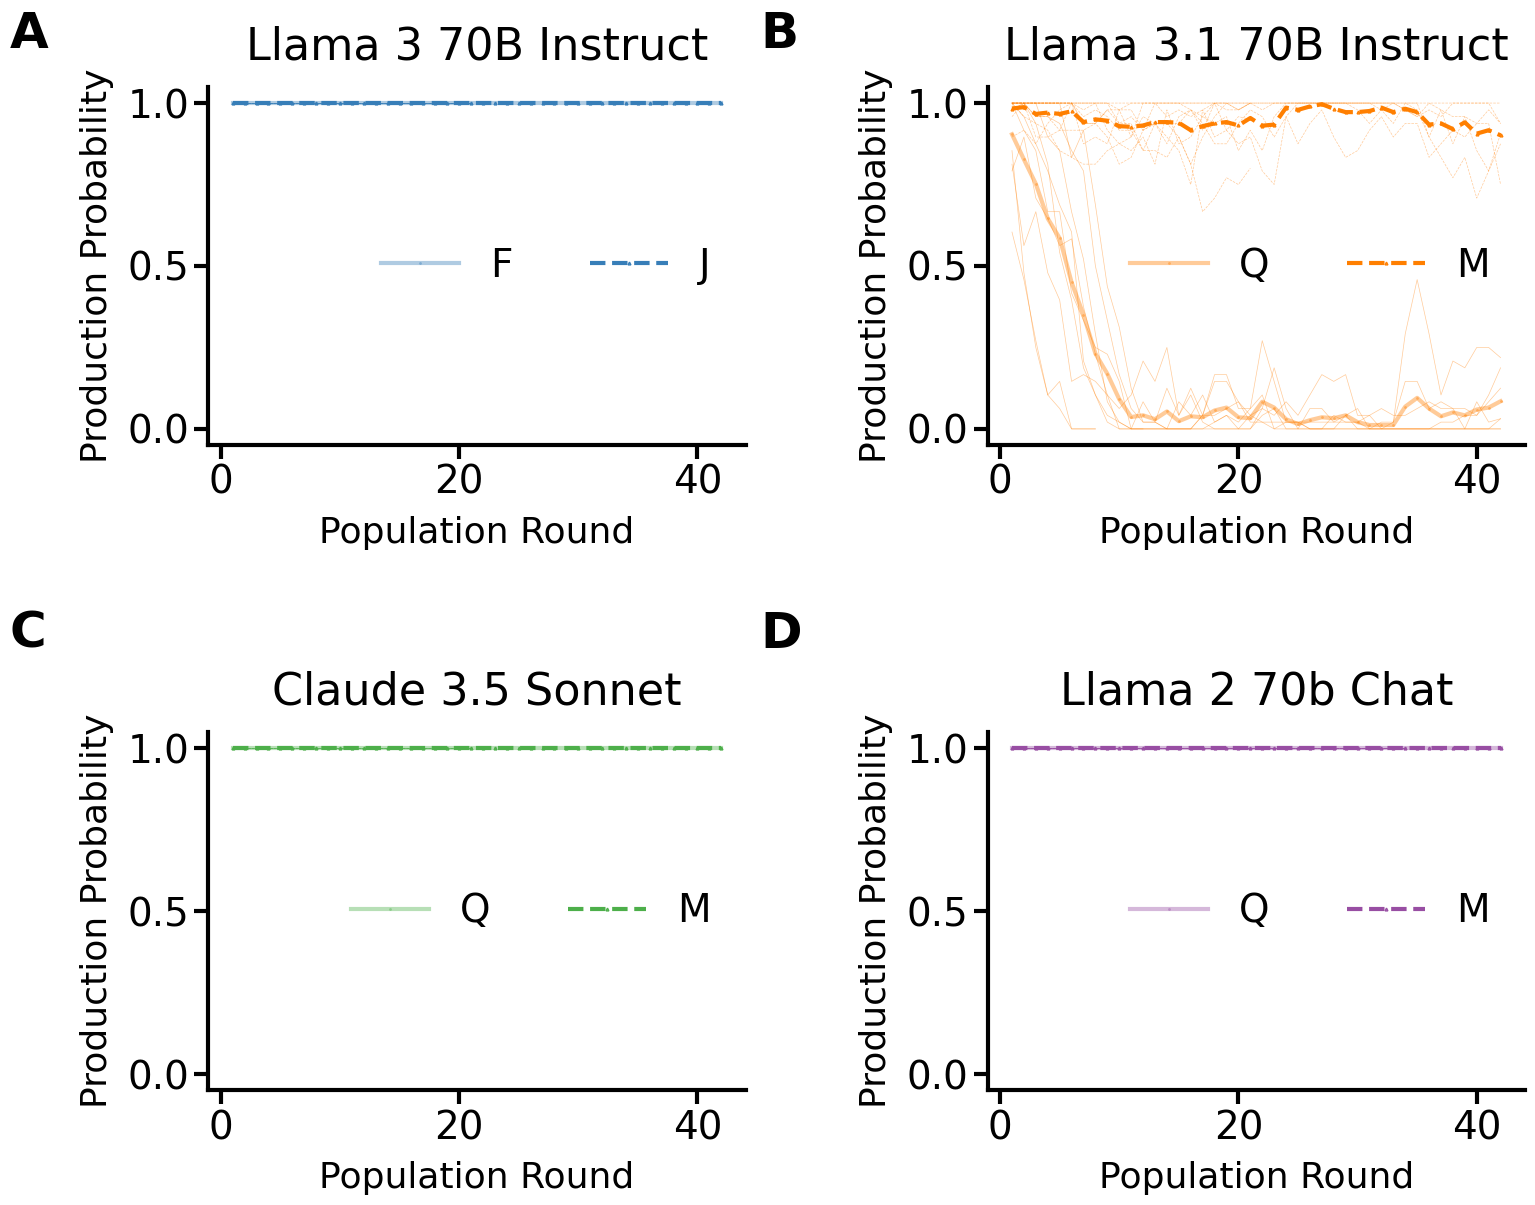

In [31]:
# plot figure
fig, axes = plt.subplots(ncols = 2, nrows = 2, figsize = (15,12))
axes = axes.flatten()
model_names=['Llama 3 70B Instruct', 'Llama 3.1 70B Instruct', 'Claude 3.5 Sonnet', 'Llama 2 70b Chat']
options_set = [['F', 'J'], ['Q', 'M'],['Q', 'M'], ['Q', 'M']]
for i in range(len(model_names)):
    ax = axes[i]
    model_color = CB_color_cycle[i]
    ls_list = cycle(['-', '--'])
    ms_list = cycle(['.', '^'])
    for key in range(len(dfs[i])):
        dataframe = dfs[i][key]
        #label = labels[key]
        ls = next(ls_list)
        ms = next(ms_list)
        average_bins = []
        bin_size = len(dataframe[0]['simulation'].keys())
        print(len(dataframe.keys()))
        for k in list(dataframe.keys()):
            if len(dataframe[k]['tracker']['outcome']) == 0:
                print(f'run {k} has not finished yet!')
                break
            # plot results over binned time
            conv_index = 0
            #history = [x for xs in dataframe[k]['tracker']['answers'][-3*len(dataframe[k]['simulation'].keys()):] for x in xs]
            word = options_set[i][key] #max(set(history), key = history.count)
            bins = []
            # separate into population rounds
            # for l in range(conv_index, len(dataframe[k]['tracker']['outcome']), bin_size):  #[dataframe[k]['converged_index']:]
            #     b = dataframe[k]['tracker']['outcome'][l:l + bin_size]
            #     bins.append(sum(b)/len(b))
            for l in range(conv_index, len(dataframe[k]['tracker']['answers']), bin_size):  
                b = [x for xs in dataframe[k]['tracker']['answers'][l:l+bin_size] for x in xs]
                bins.append(b.count(word)/len(b))
            average_bins.append(bins)
            micro_steps = [((l+1)*bin_size)/len(dataframe[k]['simulation'].keys()) for l in range(0, len(bins))]  
            #if k < 5:
            ax.plot(micro_steps, bins, lw =0.5, color = model_color, alpha = 0.4, ls = ls)
        #model_bins.append(average_bins)
        #longest_trajectory = max([len(trajectory) for trajectory in average_bins])
        #print(longest_trajectory)
        if i == 1:
            max_rounds = 0

        else:
            max_rounds = 42
        model_traj = [trajectory+[1]*(max_rounds) for trajectory in average_bins]
        avg_outcome = pd.DataFrame(model_traj).mean(axis = 0)[:42]
        steps = [((j+1)*bin_size)/len(dataframe[k]['simulation'].keys()) for j in range(0, len(avg_outcome.values))]   
        #yerr = np.std(average_bins, axis=0)/np.sqrt(len(average_bins))
        if key == 0:
            ax.plot(steps, avg_outcome.values, color=model_color,
                ls=ls, lw = 3, ms = 2, label = options_set[i][key], marker = ms, markerfacecolor = 'None', alpha = 0.4)
        else:
            ax.plot(steps, avg_outcome.values, color=model_color,
                    ls=ls, lw = 3, ms = 2, label =options_set[i][key], marker = ms, markerfacecolor = 'None')
    #ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.3), fontsize=28, ncols=2, frameon=False)  
    ax.legend(fontsize = 28, ncol = 2, frameon = False, loc = 'center right')
    ax.set_title(model_names[i], fontsize = 32, pad = 20)


    ax.set_ylabel('Production Probability', fontsize = 26, labelpad = 10)
    ax.set_xlabel('Population Round', fontsize = 26, labelpad = 10)
    ax.tick_params(axis='both', which='major', labelsize=28)
    ax.tick_params(axis='both', which='minor', labelsize=18, length=8) 
    ax.tick_params(width=3, length=10)
    for axis in ['left','bottom']:
        ax.spines[axis].set_linewidth(3)
    for axis in ['right','top']:
        ax.spines[axis].set_visible(False)

    ax.set_ylim(top = 1.05, bottom = -0.05)


add_subplot_label(fig, 'A', -0.02, 1.0)
add_subplot_label(fig, 'B', 0.48, 1.0)
add_subplot_label(fig, 'D', 0.48, 0.5)
add_subplot_label(fig, 'C',- 0.02, 0.5)
plt.tight_layout()
plt.subplots_adjust(hspace = 0.8, wspace = 0.45)
plt.savefig(f'figures/SI_FIGURE_stability.pdf', dpi = 1000, bbox_inches = 'tight', pad_inches = 0.1)
plt.show()